## 背景介绍
在前面的手写数据集(mnist)中，我们已经实现了我们的第一个神经网络的构建，并且取得了较好的验证正确率。这算完成了神经网络中的“hello world”。但是值得注意的是，这样的数据集的格式并不是我们平时看见的磁盘中的一张张图片，而是经过他人处理的后缀名为npz的文件，通常的方法无法对此文件进行读取，换言之，这样的数据集并不是实际应用中所使用的数据形式。就图片来说，若日后我们要进行神经网络项目的实现，我们首先便是收集到一些图片，根据他们对应标签的不同存放在不同的储存空间。同时，若想对前人未涉足的领域进行神经网络的应用，自然也不可能找得到别人已经处理好的数据集。所以我们有没有什么办法呢？

本教程主要介绍如何利用现实生活中真正使用的图片数据来进行神经网络的训练，以及如何使用Tensorflow对此进行实现。

## 模型概览
本次实验依旧使用的是CNN卷积神经网络。之前mnist我们知道它是像素为28 X 28的灰度图片，也就是说一张图片的格式是28 X 28 X 1。而我们这次使用的是人和马的彩色图片，像素是300 X 300，也就是说图片的格式300 X 300 X 3,因为在一个像素上有三色RGB通道，所以X3。可见此次我们这次所使用的实验数据更接近真实生活，这也是为什么在mnist数据集的实验上对CNN进行补充的原因。
同样，本次实验的最终目的也是构建一个合适的神经网络，达到我们预期的验证准确率。

## 数据准备
下面的Python代码将使用OS库，从而使您可以访问文件系统，并使用zipfile库来解压缩数据。图片的压缩包便是horse-or-human.zip。


In [1]:
import os
import zipfile

local_zip = 'tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/horse-or-human')
zip_ref.close()

horse-or-human.zip的内容被解压到基本目录/tmp/horse-or-human中，每个目录又包含马的图片和人的图片的子目录。


注意：我们没有将图像明确标记为马或人。 如果您还记得前面的手写示例，我们将其标记为“这是1”，“这是7”等。稍后，您将看到使用了一个称为ImageGenerator的东西-并将其编码为从子目录读取图像， 并从该子目录的名称中自动标记它们。 实际上现在我们只是拥有两个包含图片的目录，一个是马的图片，一个是人的图片。 Tensorflow中的ImageGenerator将为我们自动标记图像，从而减少了编码步骤。

让我们来定义这两个目录：

In [2]:
# 包含马的图片的目录
train_horse_dir = os.path.join('tmp/horse-or-human/horses')

# 包含人的图片的目录
train_human_dir = os.path.join('tmp/horse-or-human/humans')

现在，让我们来看一下马和人训练图片目录中的文件名是什么样的：

In [3]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse01-0.png', 'horse01-1.png', 'horse01-2.png', 'horse01-3.png', 'horse01-4.png', 'horse01-5.png', 'horse01-6.png', 'horse01-7.png', 'horse01-8.png', 'horse01-9.png']
['human01-00.png', 'human01-01.png', 'human01-02.png', 'human01-03.png', 'human01-04.png', 'human01-05.png', 'human01-06.png', 'human01-07.png', 'human01-08.png', 'human01-09.png']


让我们来看一下这两个目录中的图片数量：

In [4]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


现在，让我们看一些图片，以更好地了解它们到底长什么样。 首先，配置matplot参数：

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 图的参数；我们将以4x4样式输出图像
nrows = 4
ncols = 4

# 在图片间迭代所用的索引
pic_index = 0

现在，显示一批8张马和人的图片。可以重新运行这个单元格来查看另一批图片：

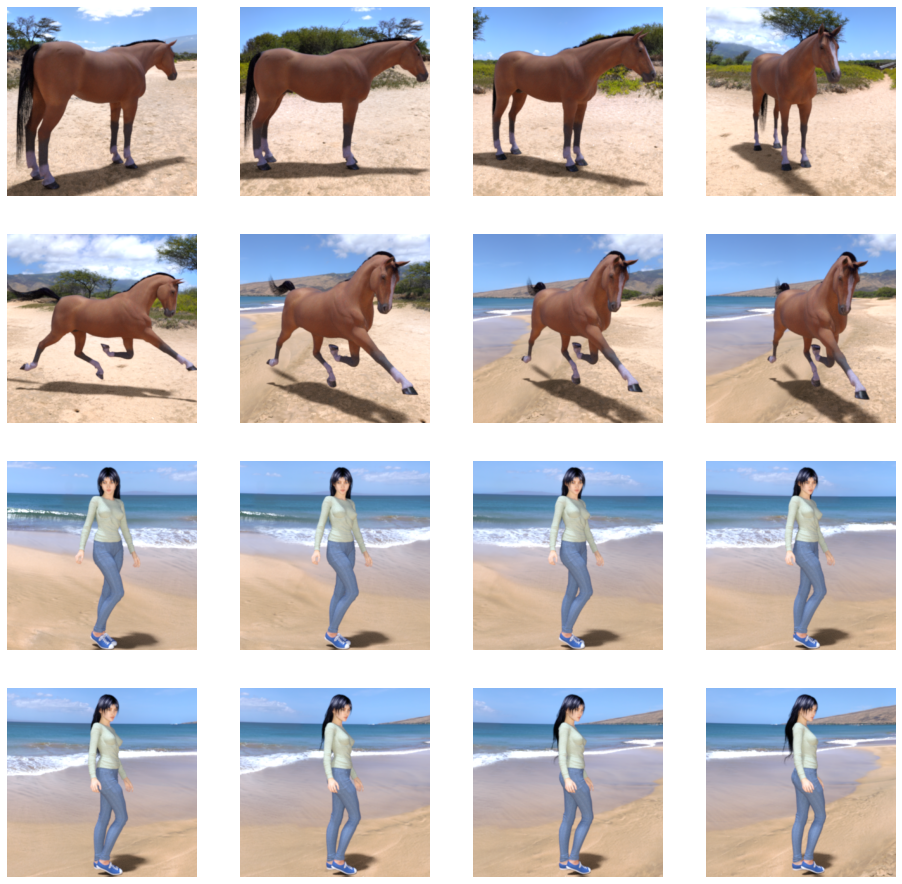

In [8]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # 设定好子图，子图下标从1开始
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # 不显示网格线

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## 从头建立一个小型模型

在我们开始前，我们先定义模型：

第一步是引入tensorflow

In [9]:
import tensorflow as tf

然后，像前面的示例一样，添加卷积层，并将最终结果展平以馈入密集连接层。

最后，我们添加密集连接层。

请注意，由于我们面临两类分类问题，即二分类问题，因此我们将以sigmoid来结束网络，以便网络的输出将是介于0和1之间的单个标量，从而编码当前图像是1类或0类。

In [10]:
model = tf.keras.models.Sequential([
    # 请注意，输入形状是3字节彩色图像300x300的所需尺寸
    # 这是第一层卷积
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # 这是第二层卷积
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # 这是第三层卷积
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # 这是第四层卷积
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # 这是第五层卷积
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # 将结果平铺以衔接密集链接网络DNN
    tf.keras.layers.Flatten(),
    # 拥有512个神经元的隐藏层
    tf.keras.layers.Dense(512, activation='relu'),
    #只有一个输出神经元。输出只会是一个在0-1之间的数据。0代表是马，1代表是人。
    tf.keras.layers.Dense(1, activation='sigmoid')
])


通过model.summary()方法来查看整个模型的概述。

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

“output shape”栏显示了feature map的大小在每个连续的图层中如何变化。 卷积层由于而使feature map的大小稍微减少了，每个池化层将尺寸减半。

我们将使用“ binary_crossentropy”损失训练我们的模型，因为这是一个二进制分类问题，而我们的最终激活是sigmoid。
我们将使用学习率为0.001的rmsprop优化器。在训练模型期间，我们将要监控分类的准确性。


**注意**: 在这个案例中, 使用[RMSprop 优化算法](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp)优于[随机梯度下降](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), 因为RMSprop会为我们自动调节学习率。 (其他优化器，如[Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam)和[Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), 也会在训练过程中自动调整学习率, 在本次实验也会得到相似的效果。)

In [13]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

### 数据预处理

让我们设置数据生成器，该数据生成器将读取源文件夹中的图片，将其转换为`float32`张量，然后将它们（带有标签）馈送到我们的网络中。 我们将为训练图像提供一个生成器，为验证图像提供一个生成器。 我们的生成器将生成一批尺寸为300x300的图像及其标签（二进制）。

你可能已经知道，进入神经网络的数据通常应该以某种方式进行规范化，以使其更易于被网络处理。（将原始像素馈送到卷积网络中是很罕见的。）在我们的实验中，我们将通过将像素值归一化为[[0，1]]范围（最初所有值都在[[0，255]]范围）。

在Keras中，这可以通过使用`rescale`参数的`keras.preprocessing.image.ImageDataGenerator`类来完成。 这个ImageDataGenerator类允许您通过.flow（data，labels）或.flow_from_directory（directory）实例化增强图像批处理（及其标签）的生成器。 然后，这些生成器可以与Keras模型的方法一起使用，这些方法接受数据生成器作为输入：“fit”，“evaluate_generator”和“predict_generator”。


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 所有图片的规模都会被调整
train_datagen = ImageDataGenerator(rescale=1/255)

# 使用train_datagen生成器分批训练图像，批次大小为128
train_generator = train_datagen.flow_from_directory(
        'tmp/horse-or-human/',  # 这是训练数据的源目录
        target_size=(300, 300),  # 所有图片都会被重新设定为300 X 300
        batch_size=128,
        # 因为我们使用binary_crossentropy损失,我们需要使用二进制标签
        class_mode='binary')


Found 1027 images belonging to 2 classes.


### 训练

让我们训练15次，可能要花几分钟的时间。

请注意每次值的变化。

损失和准确度是训练进度的重要标志。它正在猜测训练数据的分类，然后根据已知标签对其进行衡量，然后计算结果。

In [15]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1)

  ...
    to  
  ['...']
Train for 8 steps
Epoch 1/15
8/8 [==============================] - 10s 1s/step - loss: 0.7178 - accuracy: 0.5039
Epoch 2/15
8/8 [==============================] - 6s 724ms/step - loss: 1.4279 - accuracy: 0.7330
Epoch 3/15
8/8 [==============================] - 6s 699ms/step - loss: 0.4662 - accuracy: 0.8087
Epoch 4/15
8/8 [==============================] - 5s 650ms/step - loss: 0.3002 - accuracy: 0.8721
Epoch 5/15
8/8 [==============================] - 6s 800ms/step - loss: 0.1998 - accuracy: 0.9287
Epoch 6/15
8/8 [==============================] - 7s 880ms/step - loss: 0.1818 - accuracy: 0.9166
Epoch 7/15
8/8 [==============================] - 6s 747ms/step - loss: 0.1358 - accuracy: 0.9344
Epoch 8/15
8/8 [==============================] - 6s 722ms/step - loss: 0.1616 - accuracy: 0.9266
Epoch 9/15
8/8 [==============================] - 6s 713ms/step - loss: 0.1085 - accuracy: 0.9544
Epoch 10/15
8/8 [==============================] - 6s 702ms/step - loss: 0.08

### 可视化中间过程

为了了解我们的卷积网络学习了哪些功能，可以通过可视化在卷积网络中的转换方式。

让我们从训练集中选择一个随机图像，然后生成一个图形，其中每一行都是图层的输出，而行中的每一幅图像都是该输出要素图中的特定过滤器。 重新运行此单元格以生成各种训练图像的中间过程。

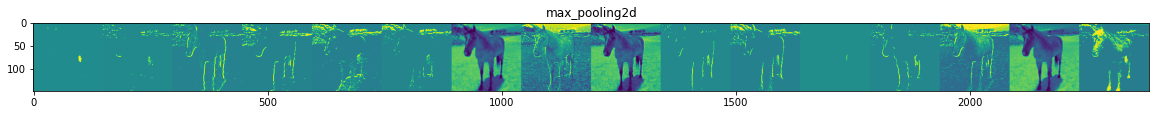

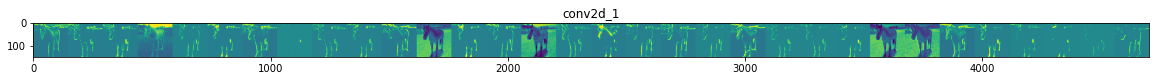

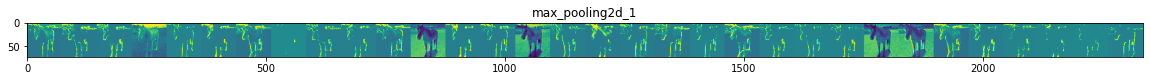

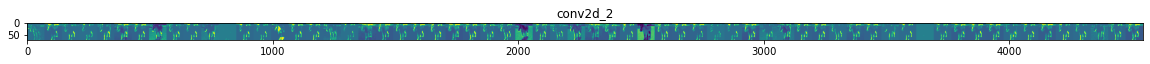

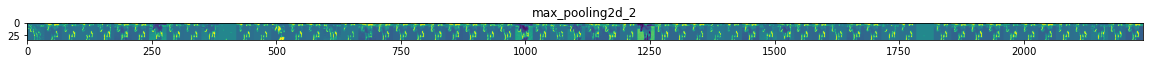

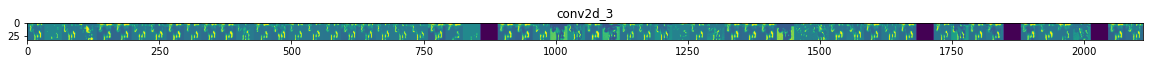

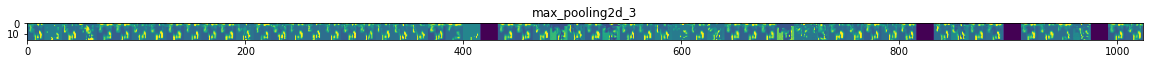

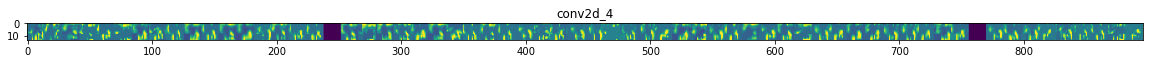

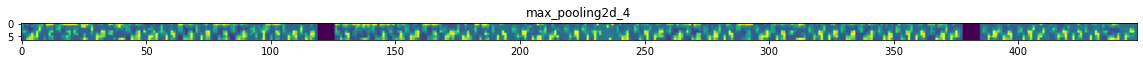

In [16]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# 让我们定义一个新模型，该模型将图像作为输入，并在第一个模型之后输出先前模型中所有层的中间表示。
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# 让我们从训练集中准备一个随机的输入图像。
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # 这是一个PIL图像
x = img_to_array(img)  # 形状(150, 150, 3)的numpy数组
x = x.reshape((1,) + x.shape)  # 形状(1，150, 150, 3)的numpy数组

x /= 255

# 让我们通过网络运行图像，从而获得该图像的所有中间过程表示。
successive_feature_maps = visualization_model.predict(x)

# 这些是图层的名称，将其作为绘图的一部分
layer_names = [layer.name for layer in model.layers[1:]]

# 现在让我们显示中间过程

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # 只经过卷积和池化层，不经过全连接层
    n_features = feature_map.shape[-1]  # 特征图的特征数量
    # 特征图的形状是(1, size, size, n_features)
    size = feature_map.shape[1]
    # 我们将在此矩阵中平铺图像
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # 对特征进行后处理以使其看起来直观
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # 我们将每个过滤器平铺到这个大的水平网格中
      display_grid[:, i * size : (i + 1) * size] = x
    # 显示这个网格
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

如您所见，我们从图像的原始像素过渡到越来越抽象和紧凑的表示形式。
下游的表示开始突出显示网络要注意的内容，并且显示“激活性(activated)”的功能越来越少。大多数设置为零。这称为“稀疏性(sparsity)”。表示稀疏性是深度学习的关键特征。


## 最后

在关闭此实验之前之前，请运行以下单元格以终止内核并释放内存资源：

In [17]:
import os, signal
os.kill(os.getpid(), signal.SIGINT)

AttributeError: module 'signal' has no attribute 'SIGKILL'